In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_data=r'E:\datasets\Teeth_Dataset\Training'
test_data=r'E:\datasets\Teeth_Dataset\Testing'
Val_data=r'E:\datasets\Teeth_Dataset\Validation'

In [3]:
# Create an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [4]:
BATCH_SIZE=16
IMG_SIZE=150

# Load train and validation data
train_gen = train_datagen.flow_from_directory(
    train_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale'
)

val_gen = val_datagen.flow_from_directory(
    Val_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale'
)

# Load test data
test_gen = test_datagen.flow_from_directory(
    test_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False  # Do not shuffle data for evaluation
)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [5]:
def plot_class_counts(generator):
    
    # Get the class distribution from the generator
    class_counts = np.unique(generator.classes, return_counts=True)[1]
    class_labels = list(generator.class_indices.keys())

    # Create a DataFrame for plotting
    label_counts_df = pd.DataFrame({
        'Class': class_labels,
        'Count': class_counts
    })

    # Plot the class distribution
    plt.figure(figsize=(10, 6))
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution')
    ax = sns.barplot(x='Class', y='Count', data=label_counts_df, palette='husl')

    # Annotate the bars with counts
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', 
                    xytext=(0, 5), textcoords='offset points')

    plt.show()

C:\Users\atiya\AppData\Local\Temp\ipykernel_11524\3695600301.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Class', y='Count', data=label_counts_df, palette='husl')


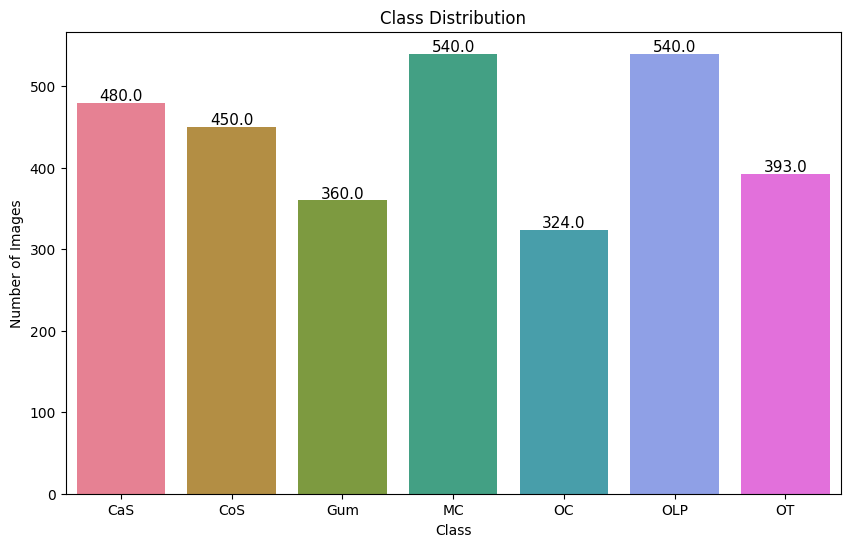

In [6]:
plot_class_counts(train_gen)

In [7]:
def plot_images_per_class(generator, num_images_per_class=3):
    
    class_indices = generator.class_indices
    class_labels = list(class_indices.keys())

    plt.figure(figsize=(15, len(class_labels) * 5))

    for i, class_label in enumerate(class_labels):
        # Filter images for the current class
        class_images = [image for image, label in zip(generator.filenames, generator.classes) if label == class_indices[class_label]]

        # Select a sample of images
        sample_images = np.random.choice(class_images, num_images_per_class, replace=False)

        for j, img_path in enumerate(sample_images):
            img = plt.imread(os.path.join(generator.directory, img_path))
            plt.subplot(len(class_labels), num_images_per_class, i * num_images_per_class + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == 1:  # Center image in each row
                plt.title(f'Class: {class_label}', fontsize=16)

    plt.tight_layout()
    plt.show()

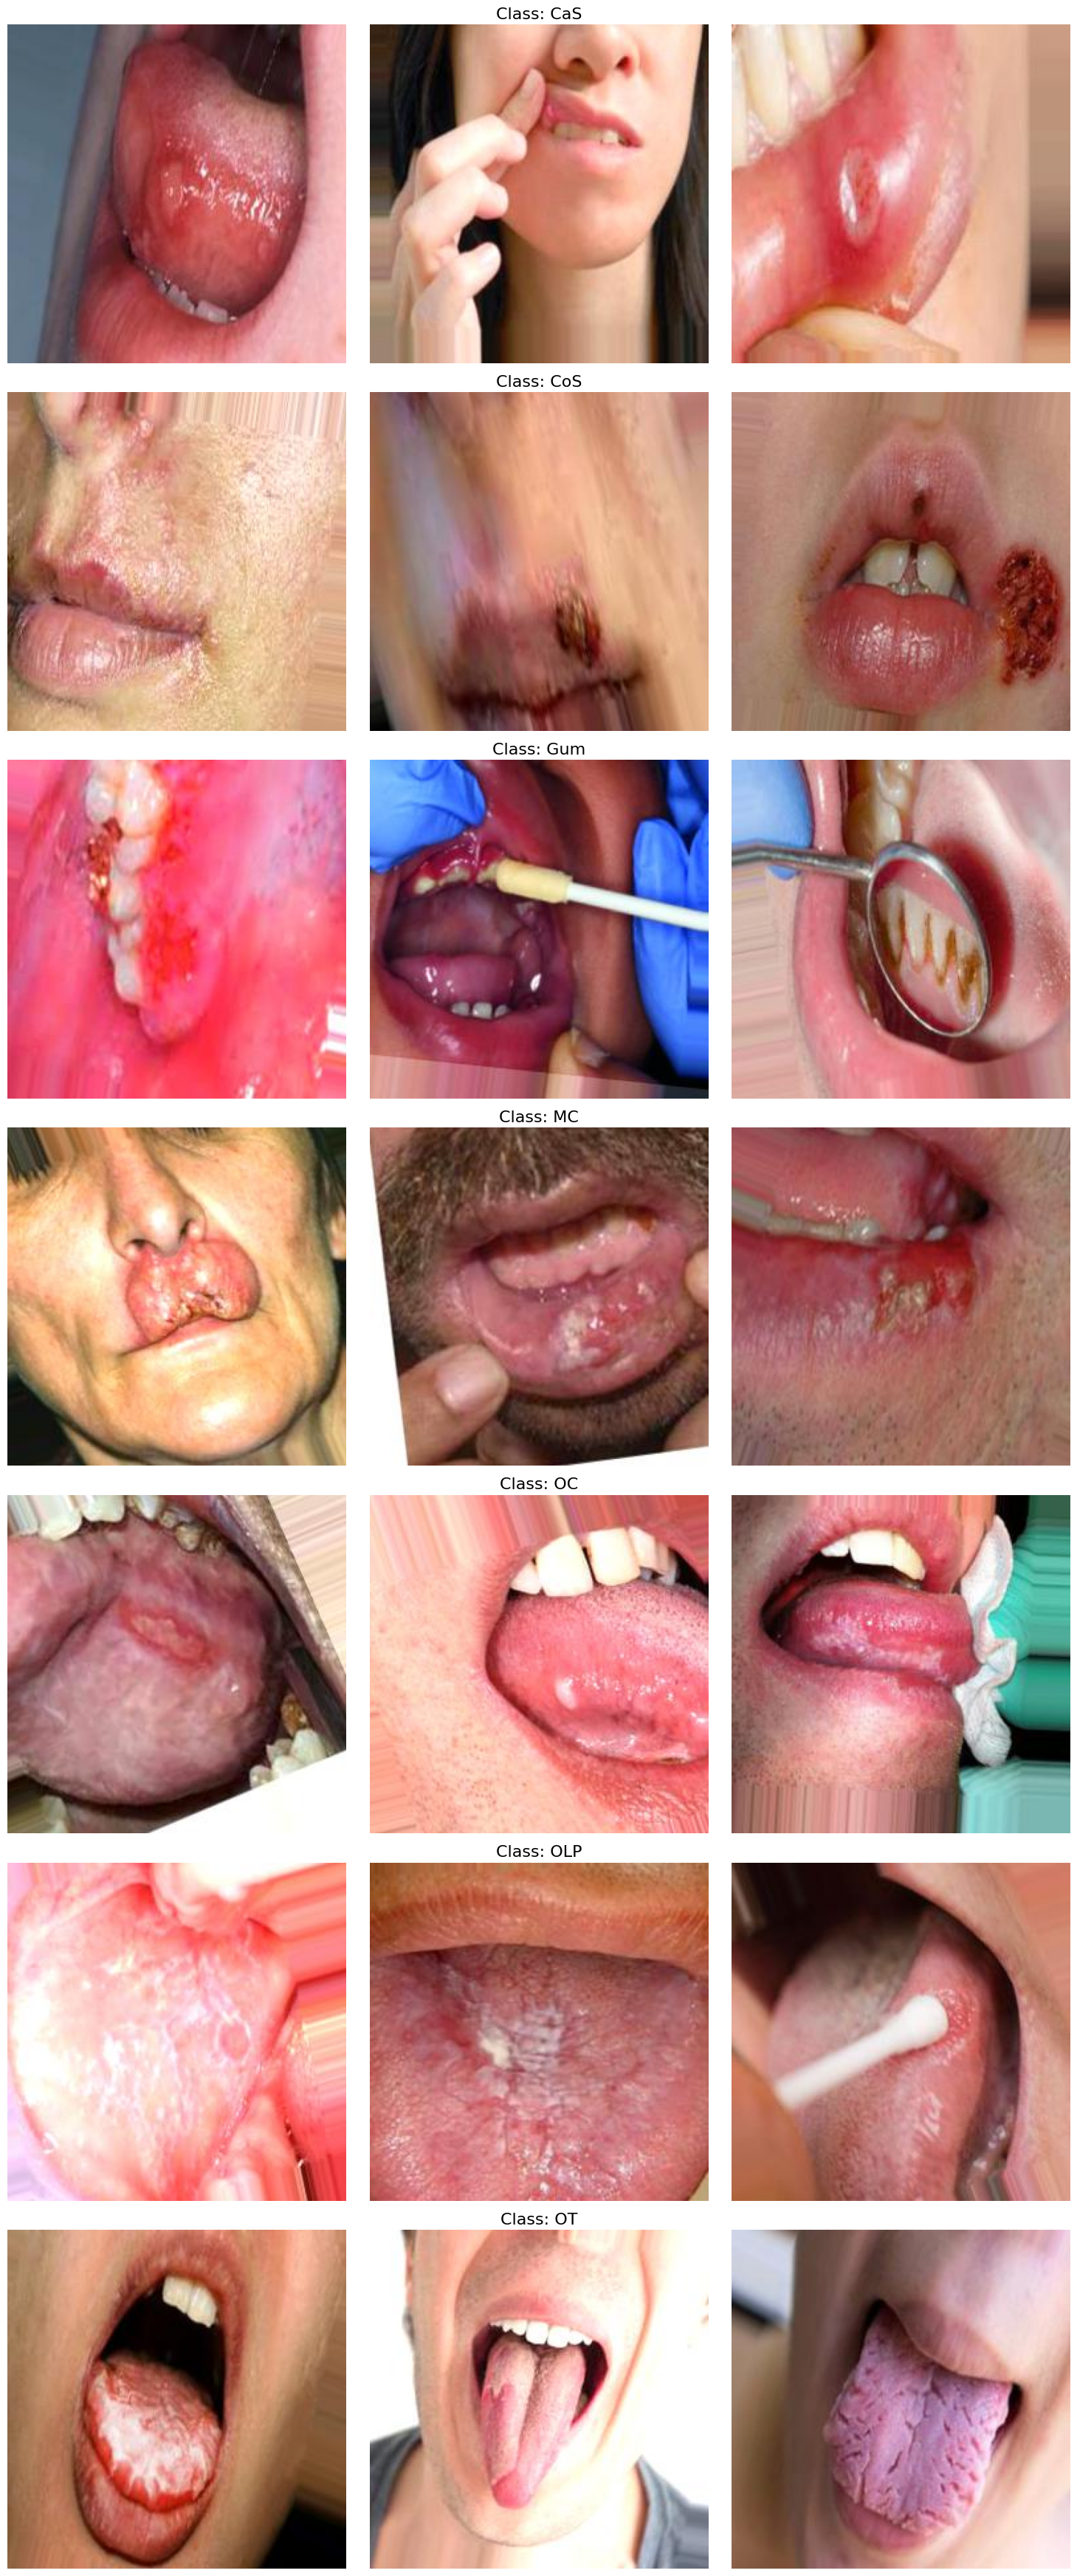

In [8]:
plot_images_per_class(train_gen)

In [9]:
# create CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# Compile the model with the RMSprop optimizer
model.compile(optimizer=Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 146, 146, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 64)        3

In [10]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [11]:
# This gets the count of each class
class_counts = np.unique(train_gen.classes, return_counts=True)[1]

# Total number of samples across all classes
total = np.sum(class_counts)

# Calculate the class weights
class_weight = {i: total / (len(class_counts) * count) for i, count in enumerate(class_counts)}

In [12]:
# Train the model
history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weight
)

Epoch 1/50
193/193 [==============================] - 17s 66ms/step - loss: 4.3938 - accuracy: 0.2242 - val_loss: 3.3533 - val_accuracy: 0.1732 - lr: 0.0010
Epoch 2/50
193/193 [==============================] - 10s 53ms/step - loss: 1.9439 - accuracy: 0.2313 - val_loss: 2.1118 - val_accuracy: 0.1839 - lr: 0.0010
Epoch 3/50
193/193 [==============================] - 11s 54ms/step - loss: 1.8877 - accuracy: 0.2420 - val_loss: 1.8731 - val_accuracy: 0.2383 - lr: 0.0010
Epoch 4/50
193/193 [==============================] - 11s 55ms/step - loss: 1.8150 - accuracy: 0.2802 - val_loss: 2.0342 - val_accuracy: 0.1877 - lr: 0.0010
Epoch 5/50
193/193 [==============================] - 11s 59ms/step - loss: 1.7616 - accuracy: 0.3084 - val_loss: 1.7440 - val_accuracy: 0.3054 - lr: 0.0010
Epoch 6/50
193/193 [==============================] - 11s 57ms/step - loss: 1.7314 - accuracy: 0.3129 - val_loss: 2.0486 - val_accuracy: 0.2160 - lr: 0.0010
Epoch 7/50
193/193 [==============================] - 11s 

In [13]:
# Evaluate the model on the validation set
test_loss, test_accuracy = model.evaluate(test_gen)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

65/65 [==============================] - 1s 17ms/step - loss: 0.8787 - accuracy: 0.6848
Test Loss: 0.8786903023719788
Test Accuracy: 0.6848248839378357


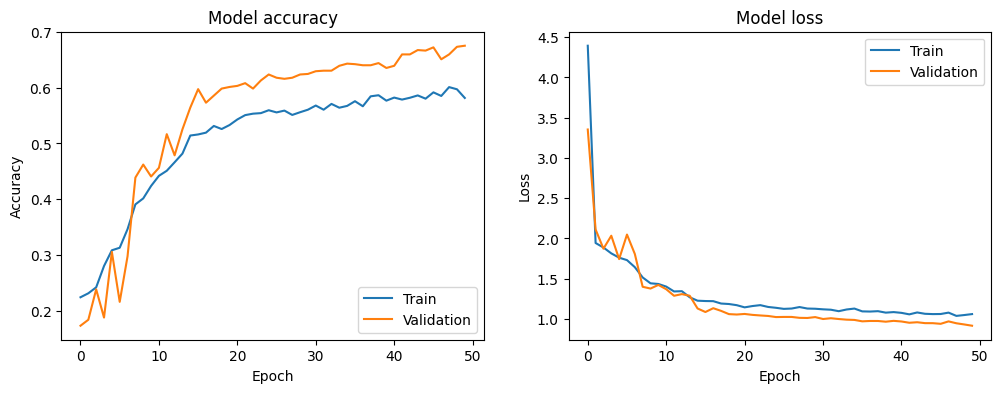

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

65/65 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

         CaS       0.78      0.74      0.76       160
         CoS       0.88      0.94      0.91       149
         Gum       0.71      0.70      0.71       120
          MC       0.61      0.54      0.57       180
          OC       0.46      0.75      0.57       108
         OLP       0.78      0.54      0.64       180
          OT       0.62      0.66      0.64       131

    accuracy                           0.68      1028
   macro avg       0.69      0.70      0.68      1028
weighted avg       0.70      0.68      0.69      1028



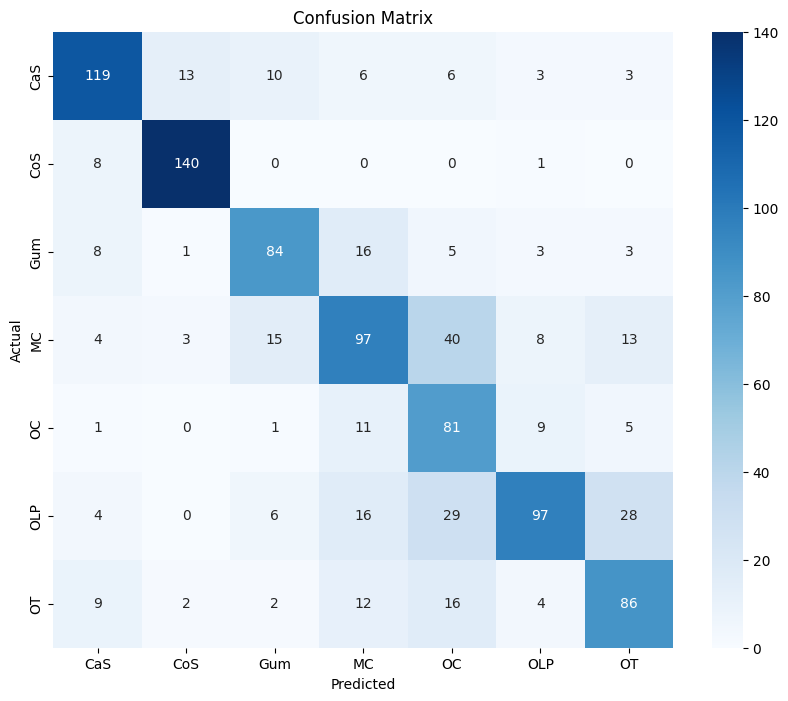

In [15]:
# Get true labels and predictions for the test set
true_labels = test_gen.classes
predictions = model.predict(test_gen)

# For multi-class classification, use argmax to get the predicted class
predicted_labels = np.argmax(predictions, axis=1)

# Extract class labels from the training generator
class_labels = list(train_gen.class_indices.keys())  # Getting class labels from the training generator

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()